In [21]:
import numpy as np 
import jax
import jax.numpy as jnp
from jax import grad, random, vmap
import optax
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import imageio
import datetime
from sklearn.decomposition import PCA, KernelPCA
from numpy import linalg as LA
import plotly.graph_objs as go
import plotly.colors as colors

In [2]:
X = np.load('/Users/ariellerosinski/My Drive/Cambridge/Project/churchland.npy') 
X = jnp.array(X) 
K, N, T = X.shape
print(X.shape)

(108, 218, 61)


In [3]:
def soft_normalize(X):
    X_norm_const = jnp.maximum(jnp.max(X, axis=(0,2),  keepdims=True ), 0.1)
    X_normalized = X / X_norm_const
    mean_across_conditions = jnp.mean(X_normalized, axis=0, keepdims=True) 
    X_normalized = X_normalized - mean_across_conditions
    return X_normalized

def normalize(X):
    mean_across_conditions = jnp.mean(X, axis=0, keepdims=True) 
    X_normalized = X - mean_across_conditions
    return X_normalized


In [ ]:
def single_pair_loss(U_tilde, X, id_1, id_2):                           #U (N,d); X(K,N,T)

    Y = jnp.einsum('ji,jk->ik', U_tilde, X[id_1, :, :])                 #(d,T)
    Y_prime = jnp.einsum('ji,jk->ik', U_tilde, X[id_2, :, :])           #(d,T)

    YY = jnp.einsum('ij,kj->ik', Y, Y_prime)                            #(d,d)
    YY_product = jnp.einsum('ij,lm->im', YY, YY)                        #(d,d)

    S_pair = jnp.trace(YY)**2 - jnp.trace(YY_product)
    return S_pair

def loss(params, X, key, s_learn):  
    K, N, T = X.shape
    if s_learn:
        U = params['U_dict']
        s = params['s_dict'] 

        s_normalized = jnp.sqrt(N) * (s**2) /  jnp.linalg.norm(s**2)
        X_scaled = s_normalized[None, :, None] * X
    else:
        U = params
        X_scaled = X
    
    U_tilde, _ = jnp.linalg.qr(U)

    num_pairs = 100  
    indices = random.randint(key, shape=(num_pairs*2,), minval=0, maxval=N)
    index_pairs = indices.reshape((num_pairs, 2))

    batched_loss = vmap(single_pair_loss, in_axes=(None, None, 0, 0))(U_tilde, X_scaled, index_pairs[:, 0], index_pairs[:, 1]) #(num_pairs)

    S = (2 / (num_pairs**2) ) * jnp.sum(batched_loss)
    return -S

def update_U(params, X, optimizer, opt_state, key, s_learn):
    dL_dU = grad(loss)(params,X,key, s_learn)
  
    updates, opt_state_updated = optimizer.update(dL_dU, opt_state, params)
    params_updated = optax.apply_updates(params, updates)
    return params_updated, opt_state_updated

def optimize_U(X, s_learn=False, iterations=10000, learning_rate=0.01, d=4, seed=42):
    K, N, T = X.shape
    key = random.PRNGKey(seed)
    
    U = random.normal(key, (N, d))
    s = random.normal(key, (N,)) 

    if s_learn:
        params = {
            'U_dict': U,
            's_dict': s
        }
    else: 
        params = U 

    keys = random.split(key, num=iterations)

    optimizer = optax.adam(learning_rate)
    opt_state = optimizer.init(params)
    
    ls_loss = []
    cmap = plt.get_cmap('viridis')
    for i in range(iterations):
        params, opt_state = update_U(params, X, optimizer, opt_state, keys[i], s_learn)
        
        ls_loss.append(loss(params, X, keys[i], s_learn))
        
        if i % 10 == 0:
            print(f"Iteration {i}, S: {-loss(params, X, keys[i], s_learn)}")
            
        if i % 100 == 0:
            plt.figure()
            plt.plot(ls_loss)
            plt.savefig(f'outputs/linear_sca/fig_saved/loss_lr_{learning_rate}_iter_{iterations}_d_{d}.png' )
            #plt.plot(params['s_dict'], color=cmap(i / (iterations - 1)))
    
    
    return params, ls_loss

s_learn = True
iterations=4000
learning_rate=0.001
d = 3
optimized_params, ls_loss = optimize_U(soft_normalize(X), s_learn, iterations, learning_rate, d)                     #optimized_U (N,d)

now = datetime.datetime.now()
date_time_str = now.strftime('%d%m%Y_%H%M%S')

save_path_U = f'outputs/linear_sca/optimized_U_linear_SCA/optimized_U_lr_{learning_rate}_iter_{iterations}_d_{d}_{date_time_str}' 

if s_learn:
    optimized_U = optimized_params['U_dict']
    
    optimized_s = optimized_params['s_dict']
    save_path_s = f'outputs/linear_sca/optimized_U_linear_SCA/optimized_S_lr_{learning_rate}_iter_{iterations}_d_{d}_{date_time_str}' 
    np.save(save_path_s, optimized_s)
else:
    optimized_U = optimized_params

np.save(save_path_U, optimized_U)

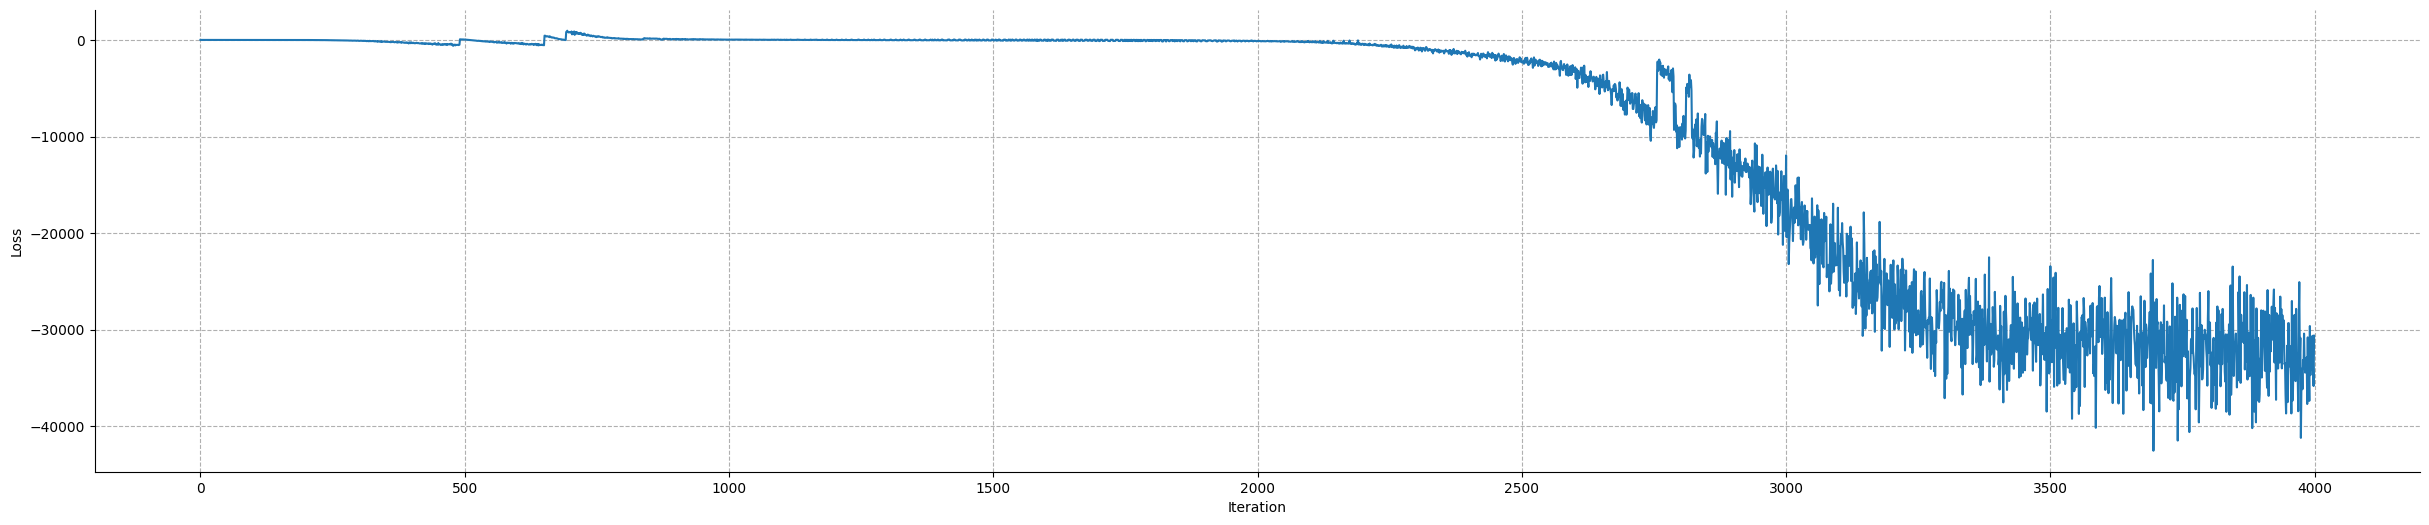

In [34]:
plt.figure(figsize=(30, 6))
plt.plot(ls_loss)
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.grid(True, which="both", ls="--") 
plt.gca().spines[['right', 'top']].set_visible(False)


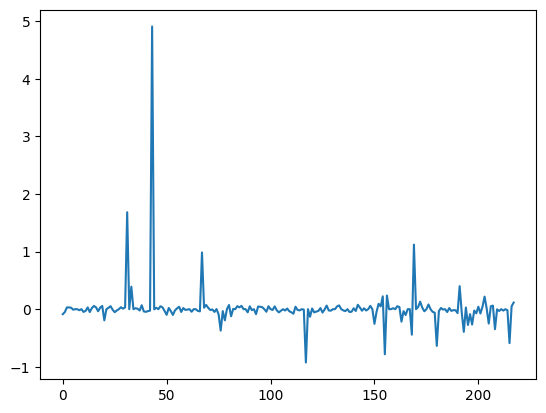

In [35]:
plt.plot(optimized_s)

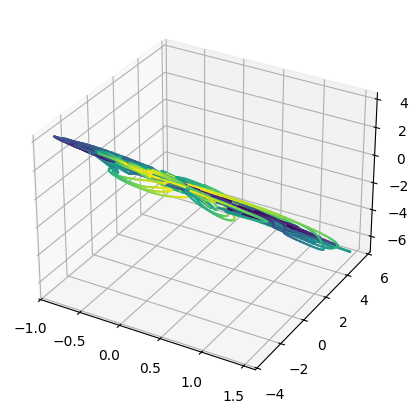

In [36]:
# threshold = 0.025
# mask = jnp.abs(optimized_s) > threshold
# indices = jnp.where(mask)[0]
# print(indices)

s_normalized = jnp.sqrt(N) * (optimized_s ** 2) / jnp.linalg.norm(optimized_s ** 2)
X_scaled = s_normalized[None, :, None] * soft_normalize(X[:,:,:])

optimized_U_tilde, _ = jnp.linalg.qr(optimized_U)        
Y = jnp.einsum('ji,kjl->kil', optimized_U_tilde[:,:], X_scaled)         #(K,d,T) 

fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(111, projection='3d')
#ax = Axes3D(fig) 
cmap = plt.get_cmap('viridis')

num_time_points = Y.shape[-1]
indices_to_plot = np.arange(0,Y.shape[0],1)

for i in indices_to_plot:
    x = Y[i, 0, :]  
    y = Y[i, 1, :] 
    z = Y[i, 2, :]  

    
    for t in range(num_time_points - 1):
        #ax.scatter(x[t:t+2], y[t:t+2], z[t:t+2], color=cmap(t / (num_time_points - 1))) 
        ax.plot(x[t:t+2], y[t:t+2], z[t:t+2], color=cmap(t / (num_time_points - 1)))




In [37]:
fig = go.Figure()

for i in indices_to_plot:
    x = Y[i, 0, :]
    y = Y[i, 1, :]
    z = Y[i, 2, :]

    for t in range(num_time_points - 1):
        color_scale = colors.sequential.Viridis
        color_index = int(t / (num_time_points - 1) * (len(color_scale) - 1))
        fig.add_trace(go.Scatter3d(
            x=x[t:t+2],
            y=y[t:t+2],
            z=z[t:t+2],
            mode='lines',
            line=dict(color=color_scale[color_index]),
            showlegend=False
        ))

fig.show()

In [10]:
def make_frame(angle):
    ax.view_init(30, angle)
    fig.canvas.draw() 
    image = np.frombuffer(fig.canvas.tostring_rgb(), dtype='uint8')
    image = image.reshape(fig.canvas.get_width_height()[::-1] + (3,))
    return image

angles = range(0, 280, 2) 
frames = [make_frame(angle) for angle in angles]

gif_path = date_time_str + "_trajectories_rotation.gif"
imageio.mimsave(gif_path, frames, fps=20)

gif_path

/var/folders/rc/1hy0j2s15dn18v_vb39s2dph0000gn/T/ipykernel_97636/4224234714.py:4: MatplotlibDeprecationWarning: The tostring_rgb function was deprecated in Matplotlib 3.8 and will be removed in 3.10. Use buffer_rgba instead.
  image = np.frombuffer(fig.canvas.tostring_rgb(), dtype='uint8')


'22052024_122353_trajectories_rotation_test_3.gif'

ENDS HERE 